# <font color='blue'>Imports </font>

In [16]:
%%time
import pandas as pd
import os
import seaborn as sns
import lightgbm
import optuna
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, log_loss, brier_score_loss, f1_score

Wall time: 0 ns


In [17]:
%%time
path = "{}\\{}\\{}\\{}\\".format(os.getcwd(), "webscrapping", "matches", "rounds")
filename = "vct_merged.csv"
dataset = pd.read_csv('{}{}'.format(path, filename))

Wall time: 4.09 s


In [18]:
dataset.columns

Index(['RoundID', 'RoundNumber', 'RoundTime', 'ATK_wealth', 'DEF_wealth',
       'ATK_alive', 'DEF_alive', 'DEF_has_OP', 'Def_has_Odin', 'RegularTime',
       'SpikeTime', 'ATK_bank', 'DEF_bank', 'ATK_initiators', 'ATK_duelists',
       'ATK_sentinels', 'ATK_controllers', 'DEF_initiators', 'DEF_duelists',
       'DEF_sentinels', 'DEF_controllers', 'ATK_Shields', 'DEF_Shields',
       'MapName', 'MatchID', 'SeriesID', 'bestOF', 'FinalWinner', 'Team_A_ID',
       'Team_A_Name', 'Team_B_ID', 'Team_B_Name'],
      dtype='object')

In [19]:
dataset.head()

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,DEF_Shields,MapName,MatchID,SeriesID,bestOF,FinalWinner,Team_A_ID,Team_A_Name,Team_B_ID,Team_B_Name
0,172040,1,0,2000,2000,5,5,0,0,0,...,100,Ascent,10425,6113,3,0,230,Take Flyte,855,Dallas Vendetta
1,172040,1,5973,1500,2000,4,5,0,0,6,...,100,Ascent,10425,6113,3,0,230,Take Flyte,855,Dallas Vendetta
2,172040,1,20664,1000,2000,3,5,0,0,21,...,100,Ascent,10425,6113,3,0,230,Take Flyte,855,Dallas Vendetta
3,172040,1,24676,1000,1500,3,4,0,0,25,...,75,Ascent,10425,6113,3,0,230,Take Flyte,855,Dallas Vendetta
4,172040,1,26225,1000,1500,3,4,0,0,26,...,75,Ascent,10425,6113,3,0,230,Take Flyte,855,Dallas Vendetta


# <font color='blue'> Predict variable </font>

In [20]:
selected_features = ['ATK_wealth', 'DEF_wealth',
                   'ATK_initiators', 'ATK_duelists', 'ATK_sentinels', 'ATK_controllers',
                   'DEF_initiators', 'DEF_duelists', 'DEF_sentinels', 'DEF_controllers',
                     'ATK_Shields', 'DEF_Shields',
                   'DEF_has_OP', 'Def_has_Odin',
                    'RegularTime', 'SpikeTime',
                   'MapName',
                   'FinalWinner']

predict_variable = 'FinalWinner'

### <font color='black'> Trimming dataframe </font>

In [21]:
dataset = dataset[selected_features]

if 'MapName' in dataset.columns:
    dataset = pd.get_dummies(dataset, columns=['MapName'])
    
X = dataset.drop([predict_variable], axis='columns')
Y = dataset[predict_variable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.9, test_size=0.1, random_state=15)

In [22]:
dataset.head()

,ATK_wealth,DEF_wealth,ATK_initiators,ATK_duelists,ATK_sentinels,ATK_controllers,DEF_initiators,DEF_duelists,DEF_sentinels,DEF_controllers,...,Def_has_Odin,RegularTime,SpikeTime,FinalWinner,MapName_Ascent,MapName_Bind,MapName_Breeze,MapName_Haven,MapName_Icebox,MapName_Split
0,2000,2000,1,2,1,1,1,2,1,1,...,0,0,0,0,1,0,0,0,0,0
1,1500,2000,1,1,1,1,1,2,1,1,...,0,6,0,0,1,0,0,0,0,0
2,1000,2000,1,1,0,1,1,2,1,1,...,0,21,0,0,1,0,0,0,0,0
3,1000,1500,1,1,0,1,1,1,1,1,...,0,25,0,0,1,0,0,0,0,0
4,1000,1500,1,1,0,1,1,1,1,1,...,0,26,0,0,1,0,0,0,0,0


# <font color='blue'>Parameter tuning </font>

In [23]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',2,100),
    max_depth = trial.suggest_int('max_depth',1,20),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',2,70),
    num_threads = trial.suggest_int('num_threads',1,10),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,10),
    
    model = lightgbm.LGBMClassifier(bagging_freq=bagging_freq,
                                    min_data_in_leaf=min_data_in_leaf,
                                   max_depth=max_depth,
                                   learning_rate=learning_rate,
                                   num_leaves=num_leaves,
                                   num_threads=num_threads,
                                   min_sum_hessian_in_leaf=min_sum_hessian_in_leaf)
    model.fit(X_train,Y_train)
    pred_proba_test = model.predict_proba(X_test)
    score = brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])
    return score

In [24]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2021-11-29 20:03:01,067] A new study created in memory with name: no-name-8ace0b0e-857a-4c7f-8a08-c6b4f42e1d95
[I 2021-11-29 20:03:04,054] Trial 0 finished with value: 0.1493330937308014 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 42, 'max_depth': 2, 'learning_rate': 0.026619737819902473, 'num_leaves': 9, 'num_threads': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 0 with value: 0.1493330937308014.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-29 20:03:19,612] Trial 1 finished with value: 0.18868562762437058 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 22, 'max_depth': 4, 'learning_rate': 0.004673475071856659, 'num_leaves': 65, 'num_threads': 1, 'min_sum_hessian_in_leaf': 3}. Best is trial 0 with value: 0.1493330937308014.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-29 20:03:33,229] Trial 2 finished with value: 0.18152640357923078 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 22, 'max_depth': 3, 'learning_rate': 0.006493172855894224, 'num_leaves': 59, 'num_threads': 1, 'min_sum_hessian_in_leaf': 1}. Best is trial 0 with value: 0.1493330937308014.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-29 20:03:46,067] Trial 3 finished with value: 0.20807277458230167 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 49, 'max_depth': 18, 'learning_rate': 0.003293424737815659, 'num_leaves': 6, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 0 with value: 0.1493330937308014.


[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-29 20:03:50,526] Trial 4 finished with value: 0.13233248966910277 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 27, 'max_depth': 20, 'learning_rate': 0.09590330542196761, 'num_leaves': 5, 'num_threads': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.13233248966910277.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-11-29 20:03:58,102] Trial 5 finished with value: 0.13631374767959928 and parameters: {'bagging_freq': 2, 'min_data_in_leaf': 68, 'max_depth': 20, 'learning_rate': 0.020781716277807394, 'num_leaves': 50, 'num_threads': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 4 with value: 0.13233248966910277.


[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-29 20:04:10,173] Trial 6 finished with value: 0.20072024185759307 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 43, 'max_depth': 10, 'learning_rate': 0.0029280028983717276, 'num_leaves': 67, 'num_threads': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.13233248966910277.


[LightGBM] [Warning] min_data_in_leaf is set=49, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=49
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-11-29 20:04:23,434] Trial 7 finished with value: 0.12909400382465258 and parameters: {'bagging_freq': 3, 'min_data_in_leaf': 49, 'max_depth': 20, 'learning_rate': 0.057577433153129444, 'num_leaves': 54, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 7 with value: 0.12909400382465258.


[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-29 20:04:32,755] Trial 8 finished with value: 0.20786675939153898 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 41, 'max_depth': 9, 'learning_rate': 0.0023992238731287852, 'num_leaves': 61, 'num_threads': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 7 with value: 0.12909400382465258.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:04:39,460] Trial 9 finished with value: 0.18350102514012703 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 83, 'max_depth': 7, 'learning_rate': 0.0048531596402991645, 'num_leaves': 28, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 7 with value: 0.12909400382465258.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:04:48,143] Trial 10 finished with value: 0.1283314228591132 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 6, 'max_depth': 14, 'learning_rate': 0.09115815321669664, 'num_leaves': 38, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 10 with value: 0.1283314228591132.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:04:56,906] Trial 11 finished with value: 0.128167197957914 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 3, 'max_depth': 15, 'learning_rate': 0.09737709148082406, 'num_leaves': 40, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:05:04,906] Trial 12 finished with value: 0.22856564938658663 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 5, 'max_depth': 14, 'learning_rate': 0.0011105441670323402, 'num_leaves': 38, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:05:12,844] Trial 13 finished with value: 0.13150952397267396 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 2, 'max_depth': 14, 'learning_rate': 0.04012645003434948, 'num_leaves': 35, 'num_threads': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-29 20:05:21,141] Trial 14 finished with value: 0.12931037985747204 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 14, 'max_depth': 14, 'learning_rate': 0.08626218754849886, 'num_leaves': 21, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:05:29,649] Trial 15 finished with value: 0.1440898251795932 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 94, 'max_depth': 16, 'learning_rate': 0.013912845529176349, 'num_leaves': 45, 'num_threads': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-29 20:05:36,088] Trial 16 finished with value: 0.13167671261559585 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 62, 'max_depth': 12, 'learning_rate': 0.0461718498705244, 'num_leaves': 23, 'num_threads': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-29 20:05:43,062] Trial 17 finished with value: 0.13386472545073613 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 10, 'max_depth': 17, 'learning_rate': 0.027064805614958547, 'num_leaves': 42, 'num_threads': 4, 'min_sum_hessian_in_leaf': 8}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-29 20:05:53,522] Trial 18 finished with value: 0.15396547735806634 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 32, 'max_depth': 12, 'learning_rate': 0.01031338062333935, 'num_leaves': 32, 'num_threads': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:06:00,124] Trial 19 finished with value: 0.13068464652310957 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 16, 'max_depth': 7, 'learning_rate': 0.0665032691111841, 'num_leaves': 17, 'num_threads': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-29 20:06:11,978] Trial 20 finished with value: 0.13111926464134052 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 33, 'max_depth': 16, 'learning_rate': 0.037261593768193615, 'num_leaves': 49, 'num_threads': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=59, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=59
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=7, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=7
[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-11-29 20:06:24,112] Trial 21 finished with value: 0.12940821933135194 and parameters: {'bagging_freq': 5, 'min_data_in_leaf': 59, 'max_depth': 18, 'learning_rate': 0.0534220523315702, 'num_leaves': 52, 'num_threads': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-11-29 20:06:32,984] Trial 22 finished with value: 0.1285958153879792 and parameters: {'bagging_freq': 4, 'min_data_in_leaf': 73, 'max_depth': 12, 'learning_rate': 0.06870058453451504, 'num_leaves': 55, 'num_threads': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 11 with value: 0.128167197957914.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:06:39,902] Trial 23 finished with value: 0.12812093774623573 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 77, 'max_depth': 12, 'learning_rate': 0.09542210298952122, 'num_leaves': 42, 'num_threads': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 23 with value: 0.12812093774623573.


[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:06:47,049] Trial 24 finished with value: 0.1282124259522263 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 85, 'max_depth': 15, 'learning_rate': 0.09009621490228589, 'num_leaves': 43, 'num_threads': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 23 with value: 0.12812093774623573.


[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:06:53,113] Trial 25 finished with value: 0.12810927715215786 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 96, 'max_depth': 8, 'learning_rate': 0.09909603687284604, 'num_leaves': 42, 'num_threads': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-29 20:06:59,568] Trial 26 finished with value: 0.13416887220535897 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 95, 'max_depth': 8, 'learning_rate': 0.02932165286191849, 'num_leaves': 30, 'num_threads': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:07:04,422] Trial 27 finished with value: 0.1390081290717022 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 99, 'max_depth': 5, 'learning_rate': 0.02058843873322233, 'num_leaves': 46, 'num_threads': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-29 20:07:11,302] Trial 28 finished with value: 0.12904885888383602 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 82, 'max_depth': 11, 'learning_rate': 0.06956609760796541, 'num_leaves': 40, 'num_threads': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-29 20:07:16,349] Trial 29 finished with value: 0.13263444563185078 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 76, 'max_depth': 6, 'learning_rate': 0.038841749502651596, 'num_leaves': 25, 'num_threads': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-29 20:07:22,311] Trial 30 finished with value: 0.12820327962009018 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 89, 'max_depth': 10, 'learning_rate': 0.09975873140770448, 'num_leaves': 35, 'num_threads': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-29 20:07:26,863] Trial 31 finished with value: 0.13084312487772576 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 89, 'max_depth': 10, 'learning_rate': 0.07022060793228903, 'num_leaves': 14, 'num_threads': 10, 'min_sum_hessian_in_leaf': 3}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:07:29,373] Trial 32 finished with value: 0.1598120443162869 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 100, 'max_depth': 1, 'learning_rate': 0.05049419534723404, 'num_leaves': 34, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:07:34,749] Trial 33 finished with value: 0.12820901210690094 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 77, 'max_depth': 8, 'learning_rate': 0.09024155341340374, 'num_leaves': 46, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-11-29 20:07:40,666] Trial 34 finished with value: 0.13257093951479076 and parameters: {'bagging_freq': 7, 'min_data_in_leaf': 90, 'max_depth': 11, 'learning_rate': 0.03371873854558121, 'num_leaves': 36, 'num_threads': 9, 'min_sum_hessian_in_leaf': 3}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=5, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=5
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-29 20:07:44,065] Trial 35 finished with value: 0.1341183464363115 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 66, 'max_depth': 3, 'learning_rate': 0.05685385606293093, 'num_leaves': 27, 'num_threads': 5, 'min_sum_hessian_in_leaf': 5}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:07:50,212] Trial 36 finished with value: 0.12844224242792723 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 54, 'max_depth': 13, 'learning_rate': 0.09777251885141651, 'num_leaves': 31, 'num_threads': 4, 'min_sum_hessian_in_leaf': 6}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:07:56,292] Trial 37 finished with value: 0.13905785025585637 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 88, 'max_depth': 10, 'learning_rate': 0.016893544094590235, 'num_leaves': 58, 'num_threads': 6, 'min_sum_hessian_in_leaf': 4}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-11-29 20:08:02,669] Trial 38 finished with value: 0.1288725179741067 and parameters: {'bagging_freq': 1, 'min_data_in_leaf': 70, 'max_depth': 9, 'learning_rate': 0.07174491964709147, 'num_leaves': 41, 'num_threads': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=5, n_jobs=-1 will be ignored. Current value: num_threads=5
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-29 20:08:07,629] Trial 39 finished with value: 0.16543309975374204 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 79, 'max_depth': 5, 'learning_rate': 0.00769958419162868, 'num_leaves': 49, 'num_threads': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=93, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=93
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=9, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=9
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-11-29 20:08:14,133] Trial 40 finished with value: 0.13052942780103552 and parameters: {'bagging_freq': 6, 'min_data_in_leaf': 93, 'max_depth': 9, 'learning_rate': 0.04689385083535049, 'num_leaves': 38, 'num_threads': 4, 'min_sum_hessian_in_leaf': 9}. Best is trial 25 with value: 0.12810927715215786.


[LightGBM] [Warning] min_data_in_leaf is set=77, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=77
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:08:19,644] Trial 41 finished with value: 0.12801084670474797 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 77, 'max_depth': 8, 'learning_rate': 0.09922828091825911, 'num_leaves': 45, 'num_threads': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.12801084670474797.


[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:08:40,410] Trial 42 finished with value: 0.12856477899405713 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 84, 'max_depth': 8, 'learning_rate': 0.07660159422589789, 'num_leaves': 45, 'num_threads': 1, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.12801084670474797.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=3, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=3
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:08:46,442] Trial 43 finished with value: 0.1299906822120147 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 72, 'max_depth': 6, 'learning_rate': 0.059793955285325384, 'num_leaves': 34, 'num_threads': 8, 'min_sum_hessian_in_leaf': 3}. Best is trial 41 with value: 0.12801084670474797.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=9, n_jobs=-1 will be ignored. Current value: num_threads=9
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:08:53,456] Trial 44 finished with value: 0.12818073576195893 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 80, 'max_depth': 13, 'learning_rate': 0.09735991887184203, 'num_leaves': 39, 'num_threads': 9, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.12801084670474797.


[LightGBM] [Warning] min_data_in_leaf is set=65, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=65
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-29 20:09:00,684] Trial 45 finished with value: 0.22372440774770092 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 65, 'max_depth': 13, 'learning_rate': 0.0013811145782894915, 'num_leaves': 48, 'num_threads': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 41 with value: 0.12801084670474797.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=2, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=2
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:09:07,060] Trial 46 finished with value: 0.12826678096984032 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 44, 'max_depth': 13, 'learning_rate': 0.07950276783576612, 'num_leaves': 53, 'num_threads': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.12801084670474797.


[LightGBM] [Warning] min_data_in_leaf is set=55, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=55
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] num_threads is set=6, n_jobs=-1 will be ignored. Current value: num_threads=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


[I 2021-11-29 20:09:13,621] Trial 47 finished with value: 0.12876684051045262 and parameters: {'bagging_freq': 10, 'min_data_in_leaf': 55, 'max_depth': 15, 'learning_rate': 0.05918034368527756, 'num_leaves': 64, 'num_threads': 6, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.12801084670474797.


[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9


[I 2021-11-29 20:09:22,604] Trial 48 finished with value: 0.12753892135150183 and parameters: {'bagging_freq': 9, 'min_data_in_leaf': 81, 'max_depth': 19, 'learning_rate': 0.09954752387701224, 'num_leaves': 70, 'num_threads': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 48 with value: 0.12753892135150183.


[LightGBM] [Warning] min_data_in_leaf is set=75, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=75
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] num_threads is set=3, n_jobs=-1 will be ignored. Current value: num_threads=3
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


[I 2021-11-29 20:09:26,619] Trial 49 finished with value: 0.14334220648747542 and parameters: {'bagging_freq': 8, 'min_data_in_leaf': 75, 'max_depth': 19, 'learning_rate': 0.049039004634379386, 'num_leaves': 3, 'num_threads': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 48 with value: 0.12753892135150183.


Wall time: 6min 25s


In [26]:
## trial = study.best_trial
print('accuracy: {}'.format(trial.value))
print('best hyperparameters: {}'.format(trial.params))

accuracy: 0.12542261079607916
best hyperparameters: {'bagging_freq': 2, 'min_data_in_leaf': 2, 'max_depth': 14, 'learning_rate': 0.09942289907056501, 'num_leaves': 70, 'num_threads': 8, 'min_sum_hessian_in_leaf': 4}


In [27]:
pd_param = pd.DataFrame([trial.params])
pd_param.to_csv('model_params.csv', index=False)

# <font color='blue'>Model </font>

In [28]:
%%time
model = lightgbm.LGBMClassifier(bagging_freq=trial.params["bagging_freq"], min_data_in_leaf=trial.params["min_data_in_leaf"],
                                max_depth=trial.params["max_depth"],
                                learning_rate=trial.params["learning_rate"], num_leaves=trial.params["num_leaves"],
                                num_threads=trial.params["num_threads"], min_sum_hessian_in_leaf=trial.params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=4, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=4
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Wall time: 6.29 s


LGBMClassifier(bagging_freq=2, learning_rate=0.09942289907056501, max_depth=14,
               min_data_in_leaf=2, min_sum_hessian_in_leaf=4, num_leaves=70,
               num_threads=8)

# <font color='blue'>Feature importance </font>

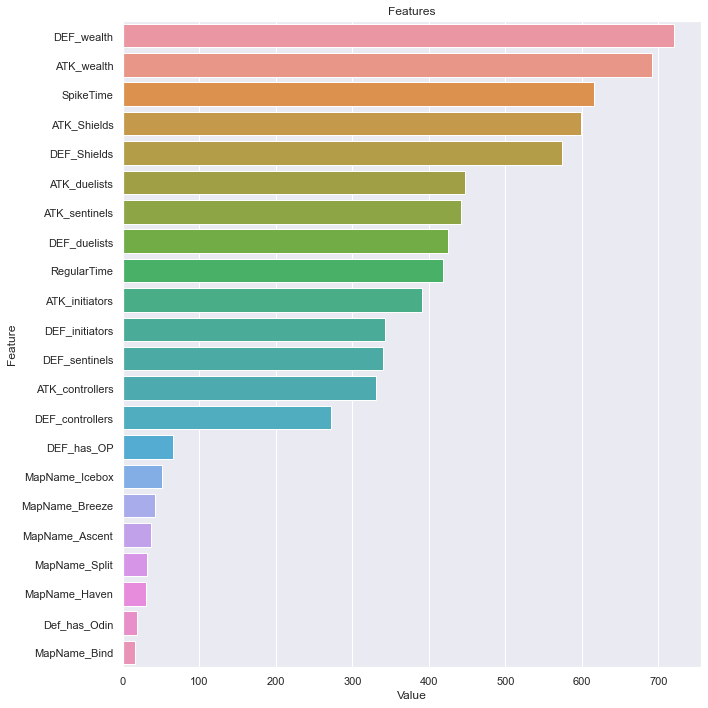

In [29]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
sns.set(font_scale = 1)
plt.title('Features')
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

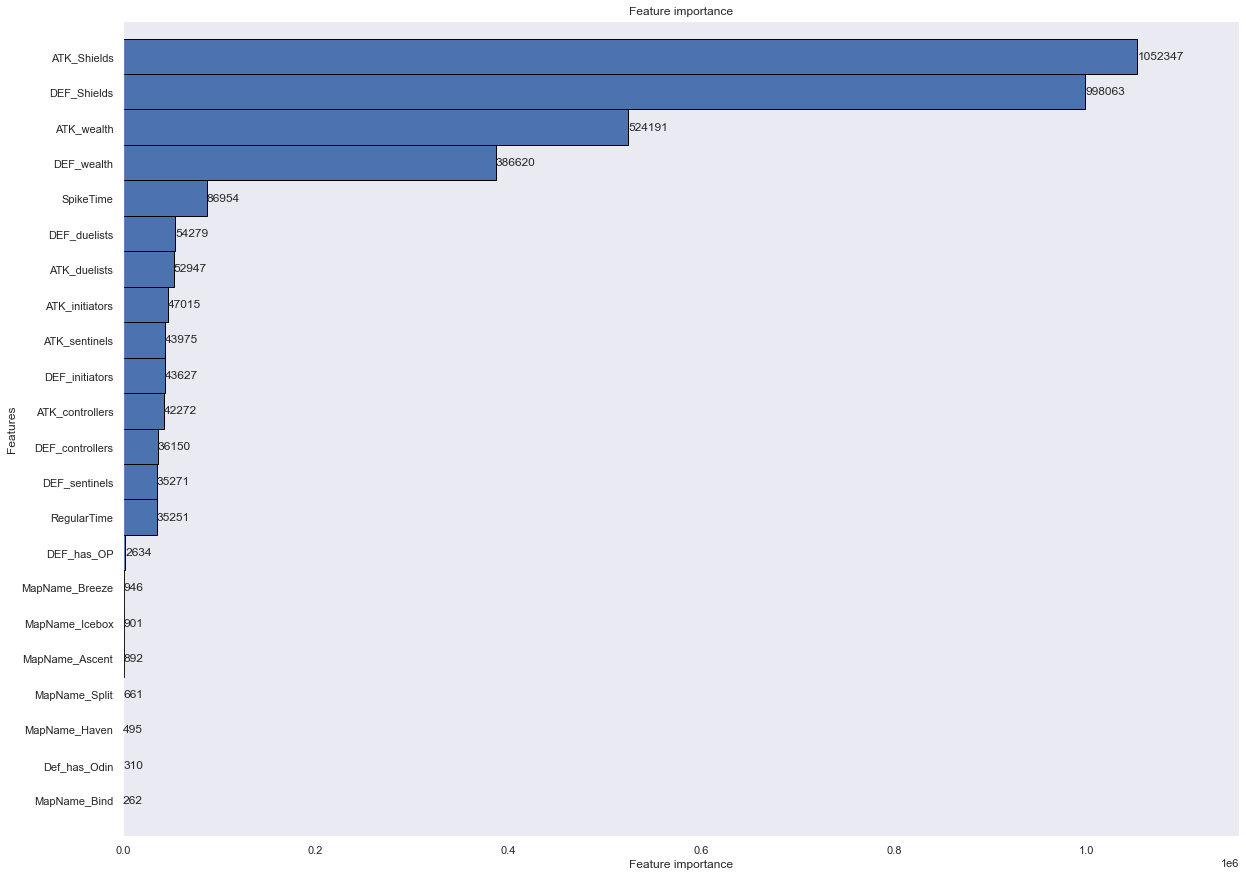

In [30]:
lightgbm.plot_importance(model, height=1, importance_type="gain", precision=0, grid=False, figsize=(20,15), edgecolor='black')

# <font color='blue'>MODEL PRECISION </font>

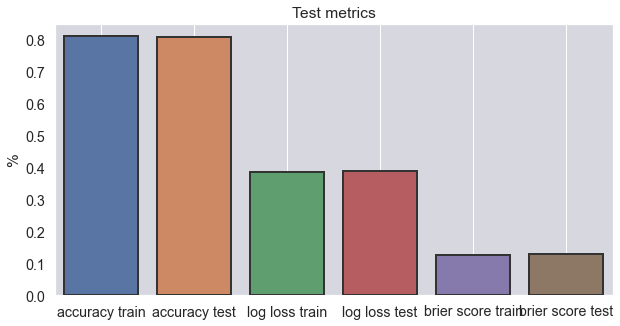

Wall time: 8.49 s


In [31]:
%%time
plt.figure(figsize = (10,5))

pred_proba = model.predict_proba(X_train)
pred_proba_test = model.predict_proba(X_test)

gmt = ["accuracy train", "accuracy test", "log loss train", "log loss test", "brier score train", "brier score test"]
metrics = {'Labels': gmt,
           'Value': [model.score(X_train, Y_train), model.score(X_test, Y_test),
                     log_loss(Y_train, pred_proba),log_loss(Y_test, pred_proba_test),
                     brier_score_loss(Y_train, pd.DataFrame(pred_proba)[1]), brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])]
           }

sns.set_context(rc = {'patch.linewidth': 2.0})
sns.set(font_scale=1.3)
ax = sns.barplot(x='Labels', y='Value', data=metrics, linewidth=2.0, edgecolor=".2", zorder=3, palette=sns.color_palette("deep"))

plt.ylabel('%')
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.grid(linewidth=1, color='white', zorder=0)
ax.set_facecolor("#d7d7e0")
plt.title("Test metrics")
plt.show()

In [32]:
print("Brier score → {}".format(brier_score_loss(Y_test, pd.DataFrame(pred_proba_test)[1])))


Brier score → 0.12759734798611577


# <font color='blue'>REALIBITY CURVE </font>

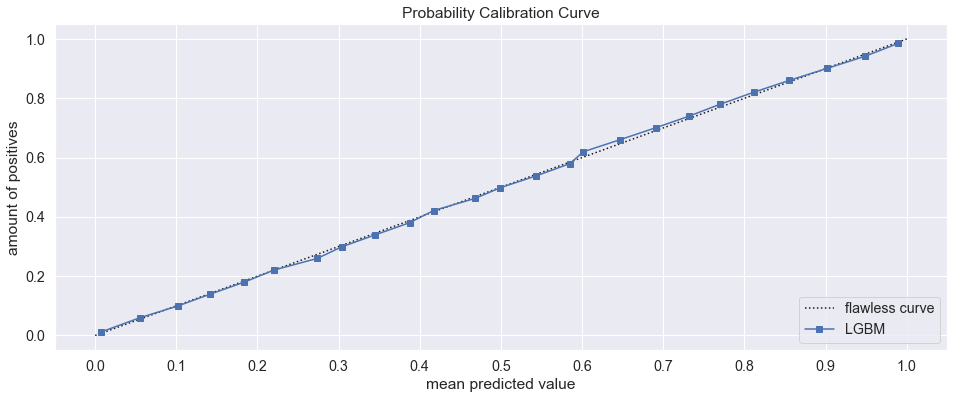

Wall time: 437 ms


Text(0.5, 0, 'mean predicted value')

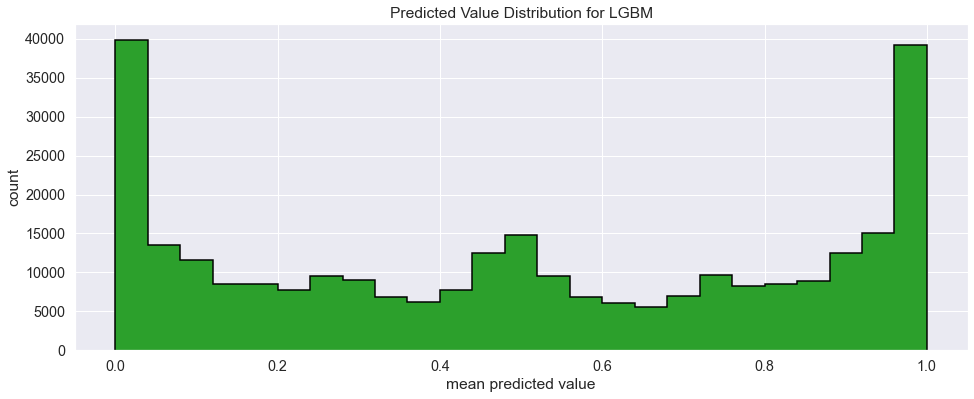

In [33]:
%%time
plt.figure(figsize=(16,6))
plt.plot([0,1], [0,1], 'k:', label='flawless curve')
x, y = calibration_curve(Y_test, pd.DataFrame(pred_proba_test)[1], n_bins=25)
plt.plot(x, y, 's-', label='LGBM')
plt.legend(loc='lower right')
plt.title('Probability Calibration Curve')
plt.ylabel('amount of positives')
plt.xlabel('mean predicted value')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show()

plt.figure(figsize=(16,6))
plt.hist(pd.DataFrame(pred_proba_test)[1], range=(0,1), bins=25, histtype="step", lw=2, fill=True, color='tab:green',
        edgecolor='black', linewidth=1.5)
plt.title('Predicted Value Distribution for LGBM')
plt.ylabel('count')
plt.xlabel('mean predicted value')

# <font color='blue'>CONFUSION MATRIX </font>

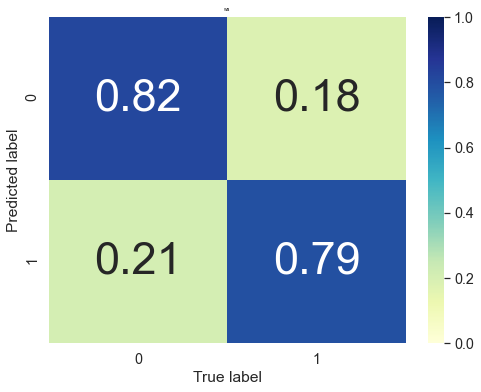

In [34]:
plt.figure(figsize = (8,6))
cm = confusion_matrix(Y_test, model.predict(X_test, num_iteration=50))
cm = (cm/cm.sum(axis=1).reshape(-1,1))

sns.heatmap(cm, cmap="YlGnBu", vmin=0., vmax=1., annot=True, annot_kws={'size':45})
plt.title("wa", fontsize = 5)
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [19]:
Y_pred = model.predict(X_test)
classification_report(Y_test, Y_pred, output_dict=True)["weighted avg"]["f1-score"]

0.8107425791483006